In [44]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt

In [45]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [46]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [47]:
# Normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [48]:
# One-hot encode the labels
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
class_num = y_test.shape[1]

In [49]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(x_train)

In [50]:
# Define the model
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=x_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, kernel_constraint=maxnorm(3), activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(128, kernel_constraint=maxnorm(3), activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(class_num, activation='softmax'))

In [51]:
# Compile the model
optimizer = 'adam'
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_3 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 dropout_24 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_21 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 64)        18496     
                                                      

In [52]:
# Learning rate scheduler
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.5
    if epoch > 20:
        lr *= 0.5
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

In [53]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [54]:
# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    validation_data=(x_test, y_test),
                    epochs=50,
                    callbacks=[lr_scheduler, early_stopping])

Epoch 1/50
782/782 [==============================] - 13s 15ms/step - loss: 1.6512 - accuracy: 0.4081 - val_loss: 1.3250 - val_accuracy: 0.5525 - lr: 0.0010
Epoch 2/50
782/782 [==============================] - 11s 14ms/step - loss: 1.2080 - accuracy: 0.5686 - val_loss: 1.1549 - val_accuracy: 0.6102 - lr: 0.0010
Epoch 3/50
782/782 [==============================] - 11s 15ms/step - loss: 1.0101 - accuracy: 0.6437 - val_loss: 0.8378 - val_accuracy: 0.7068 - lr: 0.0010
Epoch 4/50
782/782 [==============================] - 11s 14ms/step - loss: 0.9151 - accuracy: 0.6800 - val_loss: 0.8566 - val_accuracy: 0.7080 - lr: 0.0010
Epoch 5/50
782/782 [==============================] - 11s 14ms/step - loss: 0.8506 - accuracy: 0.7044 - val_loss: 0.8434 - val_accuracy: 0.7033 - lr: 0.0010
Epoch 6/50
782/782 [==============================] - 12s 15ms/step - loss: 0.8060 - accuracy: 0.7202 - val_loss: 0.6845 - val_accuracy: 0.7617 - lr: 0.0010
Epoch 7/50
782/782 [==============================] - 12s 

In [57]:
# Evaluate the model
scores = model.evaluate(x_test, y_test, verbose=0)
print(f"Accuracy: {scores[1]*100:.2f}%")

Accuracy: 85.77%


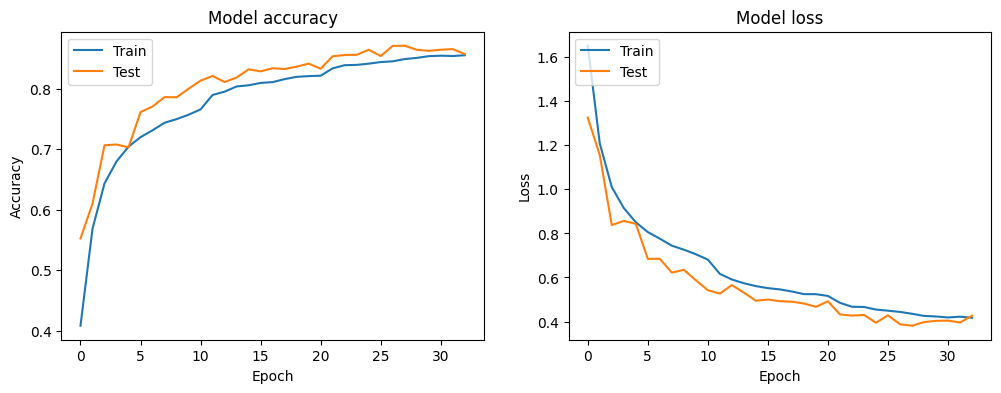

In [58]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()